In [1]:
import os
import numpy as np
import pyvista as pv
from sklearn.cluster import DBSCAN
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


C:\Users\draks\AppData\Roaming\Python\Python39\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


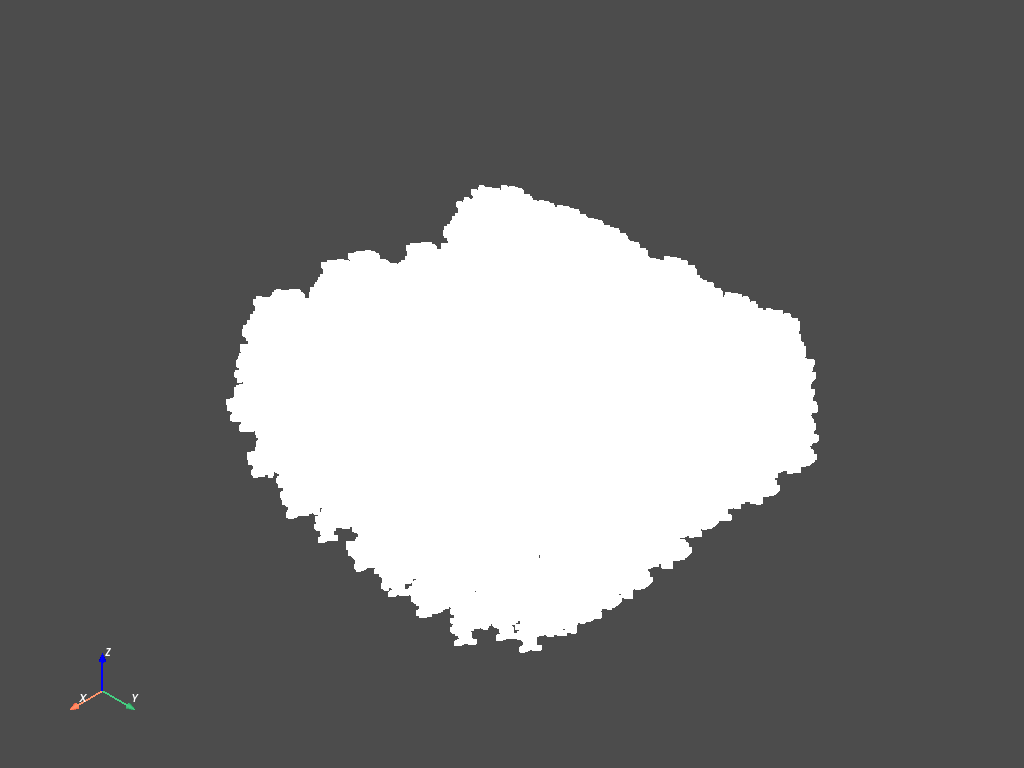

In [2]:
# define the directory containing the XYZ files
directory = 'D:/Helios-Automated_XML/Results/1st-points'

# get a list of file names in the directory
file_names = os.listdir('D:/Helios-Automated_XML/Results/1st-points')

# create an empty list to hold the PyVista objects
mesh_list = []

# loop over each file and read it into a PyVista object
for file_name in file_names:
    # check if the file is an XYZ file
    if file_name.endswith('.xyz'):
        # construct the full file path
        file_path = os.path.join(directory, file_name)

        # read the XYZ file into a numpy array, using only the first 3 columns
        points = np.loadtxt(file_path, usecols=(0, 1, 2))

        # create a PyVista points object from the numpy array
        mesh = pv.PolyData(points)

        # add the mesh to the list
        mesh_list.append(mesh)

# merge the meshes into a single PyVista object
merged_mesh = pv.MultiBlock(mesh_list).combine()

# display the merged mesh
merged_mesh.plot()

In [3]:
from vtk import vtkPLYWriter

# Create a PLY writer
writer = vtkPLYWriter()

# Set the input datahttp://localhost:8888/notebooks/Tree_identfication.ipynb#
writer.SetInputData(mesh)

# Set the file name and save the mesh to PLY
writer.SetFileName("D:/Helios-Automated_XML/Results/1st-points/mesh.ply")
writer.Update()

In [ ]:
# Step 1: Preprocessing
pcd = o3d.io.read_point_cloud("D:/Helios-Automated_XML/Results/1st-points/mesh.ply")
ground_removed_pcd, ind = pcd.remove_statistical_outlier(nb_neighbors=20,std_ratio=2.0)
ground_removed_pcd = ground_removed_pcd.voxel_down_sample(voxel_size=0.2)
ground_plane = ground_removed_pcd.segment_plane(distance_threshold=0.2,ransac_n=3, num_iterations=1000)
inliers = np.asarray(ground_removed_pcd.voxel_down_sample(voxel_size=0.2).select_by_index(np.array(ind)[ground_plane[1]])).reshape(-1, 3)
outliers = np.asarray(ground_removed_pcd.voxel_down_sample(np.array(ind)[ground_plane[1]], invert=True)).reshape(-1, 3)

# Step 2: Segmentation
clustering = DBSCAN(eps=0.6, min_samples=10).fit(outliers)
labels = clustering.labels_
max_label = labels.max()
trees = []
for i in range(max_label + 1):
    mask = labels == i
    if np.sum(mask) > 0:
        trees.append(outliers[mask])

# Step 3: Crown delineation
crowns = []
for i in range(len(trees)):
    tree = trees[i]
    tree_pcd = o3d.geometry.PointCloud()
    tree_pcd.points = o3d.utility.Vector3dVector(tree)
    distances = tree_pcd.compute_nearest_neighbor_distance()
    avg_distance = np.mean(distances)
    radii = [1.5 * avg_distance, 2.0 * avg_distance]
    _, points_idx = tree_pcd.hidden_point_removal(np.asarray(radii))
    crown = np.asarray(tree_pcd.select_down_sample(points_idx).points)
    crowns.append(crown)

# Step 4: Crown modeling
models = []
for i in range(len(crowns)):
    crown = crowns[i]
    alpha_shape = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(o3d.geometry.PointCloud(o3d.utility.Vector3dVector(crown)), alpha=1.0)
    model = np.asarray(alpha_shape.vertices)
    models.append(model)

# Step 5: Crown characterization
volumes = []
for i in range(len(models)):
    model = models[i]
    hull = ConvexHull(model)
    volume = hull.volume
    volumes.append(volume)

# Step 6: Crown classification
classes = []
for i in range(len(volumes)):
    volume = volumes[i]
    if volume < 10:
        classes.append("small")
    elif volume >= 10 and volume < 100:
        classes.append("medium")
    else:
        classes.append("large")

# Step 7: Crown mapping
tree_crowns = {}
for i in range(len(crowns)):
    tree_crowns[i] = {"crown": crowns[i], "class": classes[i]}
